In [ ]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

Using tiingo API to get stock data. we are using Vedanta stock here

In [ ]:
raw_data = pdr.get_data_tiingo("VEDL",api_key ="****redacted****" )

In [ ]:
raw_data.shape

(1221, 12)

In [ ]:
raw_data.to_csv("vedanta_data.csv")

In [ ]:
raw_data

close   high    low   open  volume  \
symbol date                                                            
VEDL   2018-07-09 00:00:00+00:00  13.18  13.27  12.97  12.97  433230   
       2018-07-10 00:00:00+00:00  13.15  13.15  13.01  13.14  373200   
       2018-07-11 00:00:00+00:00  12.47  12.74  12.47  12.65  437496   
       2018-07-12 00:00:00+00:00  12.36  12.43  12.19  12.31  534100   
       2018-07-13 00:00:00+00:00  12.22  12.30  12.15  12.18  304830   
...                                 ...    ...    ...    ...     ...   
       2023-05-08 00:00:00+00:00  16.50  16.50  16.50  16.50       0   
       2023-05-09 00:00:00+00:00  16.50  16.50  16.50  16.50       0   
       2023-05-10 00:00:00+00:00  16.50  16.50  16.50  16.50       0   
       2023-05-11 00:00:00+00:00  16.50  16.50  16.50  16.50       0   
       2023-05-12 00:00:00+00:00  16.50  16.50  16.50  16.50       0   

                                   adjClose    adjHigh     adjLow    adjOpen  \
symbol date                                                                    
VEDL   2018-07-09 00:00:00+00:00   9.954010  10.021981   9.795410   9.795410   
       2018-07-10 00:00:00+00:00   9.931353   9.931353   9.825620   9.923801   
       2018-07-11 00:00:00+00:00   9.417792   9.621706   9.417792   9.553735   
       2018-07-12 00:00:00+00:00   9.334716   9.387583   9.206326   9.296955   
       2018-07-13 00:00:00+00:00   9.228983   9.289402   9.176117   9.198774   
...                                     ...        ...        ...        ...   
       2023-05-08 00:00:00+00:00  16.500000  16.500000  16.500000  16.500000   
       2023-05-09 00:00:00+00:00  16.500000  16.500000  16.500000  16.500000   
       2023-05-10 00:00:00+00:00  16.500000  16.500000  16.500000  16.500000   
       2023-05-11 00:00:00+00:00  16.500000  16.500000  16.500000  16.500000   
       2023-05-12 00:00:00+00:00  16.500000  16.500000  16.500000  16.500000   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
VEDL   2018-07-09 00:00:00+00:00     433230      0.0          1.0  
       2018-07-10 00:00:00+00:00     373200      0.0          1.0  
       2018-07-11 00:00:00+00:00     437496      0.0          1.0  
       2018-07-12 00:00:00+00:00     534100      0.0          1.0  
       2018-07-13 00:00:00+00:00     304830      0.0          1.0  
...                                     ...      ...          ...  
       2023-05-08 00:00:00+00:00          0      0.0          1.0  
       2023-05-09 00:00:00+00:00          0      0.0          1.0  
       2023-05-10 00:00:00+00:00          0      0.0          1.0  
       2023-05-11 00:00:00+00:00          0      0.0          1.0  
       2023-05-12 00:00:00+00:00          0      0.0          1.0  

[1221 rows x 12 columns]

We have daily data from July 2018 to May 2023. Total of 1221 entries.
The data does not have any valuabe info after "2021-11-10". After this date the feature values are all same.

"Adjusted closing price refers to the price of the stock after paying off the dividends. For instance, if a stock is priced at Rs. 100 and gives a dividend of INR5 per share, then its adjusted closing price would be Rs. 95"  => Source - [angelone.com](https://www.angelone.in/knowledge-center/share-market/difference-between-closing-price-and-adjusted-closing-price#:~:text=Adjusted%20closing%20price%20refers%20to,95.)


Our aim will be to forecast price for a month using univariate forecasting techniques



In [ ]:
def parser(input_date):
  return datetime.strptime(input_date[:10], "%Y-%m-%d")

In [ ]:
data = pd.read_csv("vedanta_data.csv",index_col = "date",usecols=["date","open","adjOpen"], parse_dates = ["date"],date_parser = parser)
print(data.head(5))
print(data.info())

             open   adjOpen
date                       
2018-07-09  12.97  9.795410
2018-07-10  13.14  9.923801
2018-07-11  12.65  9.553735
2018-07-12  12.31  9.296955
2018-07-13  12.18  9.198774
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1221 entries, 2018-07-09 to 2023-05-12
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     1221 non-null   float64
 1   adjOpen  1221 non-null   float64
dtypes: float64(2)
memory usage: 28.6 KB
None


In [ ]:
df = data.loc[:"2021-11-10"]
df

,open,adjOpen
date,,
2018-07-09,12.97,9.795410
2018-07-10,13.14,9.923801
2018-07-11,12.65,9.553735
2018-07-12,12.31,9.296955
2018-07-13,12.18,9.198774
...,...,...
2021-11-04,16.52,16.520000
2021-11-05,16.54,16.540000
2021-11-08,17.01,17.010000


It is found by comparing stock prices of the same date that the stock price in our data was lower than the original stock price by a factor of 17.27 rupees

In [ ]:
df["price"] = df["open"]*17.2783251
df["adj_price"] = df["adjOpen"]*17.2783251
df.head(5)

<ipython-input-152-fb6d9b19644b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price"] = df["open"]*17.2783251
<ipython-input-152-fb6d9b19644b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["adj_price"] = df["adjOpen"]*17.2783251


,open,adjOpen,price,adj_price
date,,,,
2018-07-09,12.97,9.795410,224.099877,169.248285
2018-07-10,13.14,9.923801,227.037192,171.466652
2018-07-11,12.65,9.553735,218.570813,165.072537
2018-07-12,12.31,9.296955,212.696182,160.635805
2018-07-13,12.18,9.198774,210.450000,158.939408


In [ ]:
df.drop(columns =["open","adjOpen"],inplace = True)

<ipython-input-153-c76527853e8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns =["open","adjOpen"],inplace = True)


Pickling the dataset to save all datatypes and formatting as is.

In [ ]:
import pickle
with open ("vedanta.obj","wb") as file:
  pickle.dump(df,file)

In [ ]:
with open("vedanta.obj","rb") as file:
  df = pickle.load(file)

In [ ]:
df.head(5)

,price,adj_price
date,,
2018-07-09,224.099877,169.248285
2018-07-10,227.037192,171.466652
2018-07-11,218.570813,165.072537
2018-07-12,212.696182,160.635805
2018-07-13,210.450000,158.939408


<Axes: title={'center': 'Vedanta opening price from 2018 to 2021'}, xlabel='date', ylabel='stock price'>

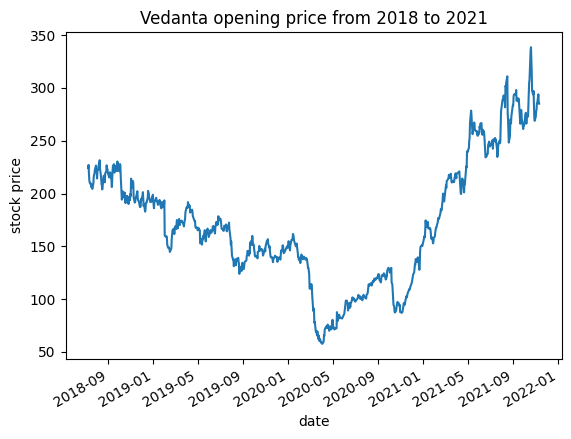

In [ ]:
plt.title("Vedanta opening price from 2018 to 2021")
df["price"].plot(xlabel = "date", ylabel = "stock price")

Below is the 5 year chart from google finance for comparison

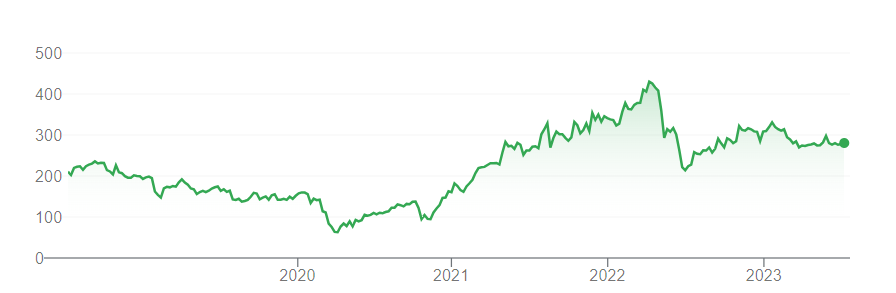

Decomposing our time series to observe trend and seasonality

<Figure size 1500x500 with 0 Axes>

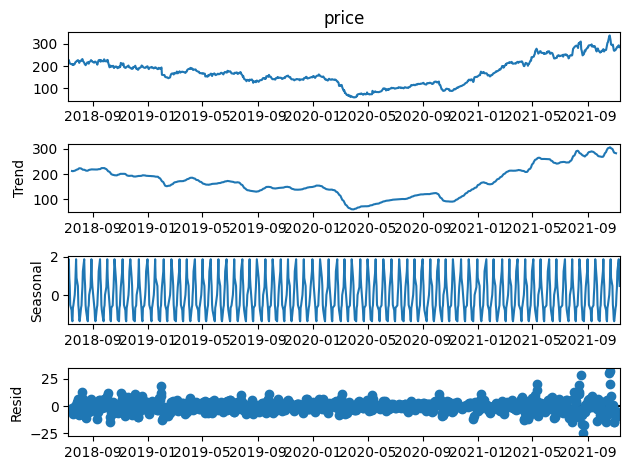

In [ ]:
plt.figure(figsize=(15,5))
decompStock = sm.tsa.seasonal_decompose(df["price"],model = "additive",period= 12)
decompStock.plot()
plt.show()

We have a additive seasonality in our series because the residual does not show much of a pattern.

In [ ]:
Quarterly = df["price"].resample("QS").sum()
Quarterly

date
2018-07-01    12882.891978
2018-10-01    12480.998136
2019-01-01    10605.608730
2019-04-01    10694.592104
2019-07-01     9511.372401
2019-10-01     9236.128682
2020-01-01     7473.393956
2020-04-01     5152.742111
2020-07-01     7234.261936
2020-10-01     7223.031025
2021-01-01    11415.098261
2021-04-01    15246.912418
2021-07-01    17327.654718
2021-10-01     8382.233856
Freq: QS-JAN, Name: price, dtype: float64

Checking for null values or missing data

In [ ]:
print(df.isnull().any())
print(df.isna().any())

price        False
adj_price    False
dtype: bool
price        False
adj_price    False
dtype: bool


In [ ]:
df1 = df.drop(columns = "adj_price")
df1.head()

,price
date,
2018-07-09,224.099877
2018-07-10,227.037192
2018-07-11,218.570813
2018-07-12,212.696182
2018-07-13,210.450000


In [ ]:
Quarterly_mean = pd.pivot_table(data = df1, index = df1.index.year,columns = df1.index.quarter,values = "price",aggfunc ={"price" : "mean"})
Quarterly_mean = Quarterly_mean.rename_axis(["Year"])
Quarterly_mean = Quarterly_mean.rename_axis(["Quarter"],axis = 1)
Quarterly_mean.reset_index()

print(Quarterly_mean)

Quarter           1           2           3           4
Year                                                   
2018            NaN         NaN  218.354101  198.111082
2019     173.862438  169.755430  148.615194  144.314511
2020     120.538612   81.789557  113.035343  112.859860
2021     187.132758  242.014483  270.744605  289.042547


<Axes: title={'center': 'Vedanta quarterly average opening price'}, xlabel='Year', ylabel='opening price'>

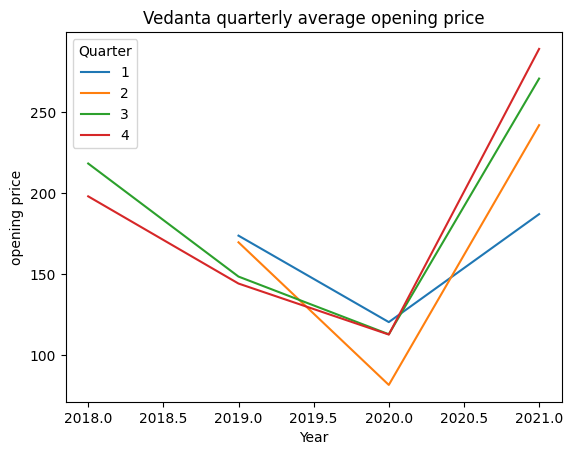

In [ ]:
Quarterly_mean.plot(xlabel = "Year", ylabel = "opening price", title="Vedanta quarterly average opening price")

<Axes: >

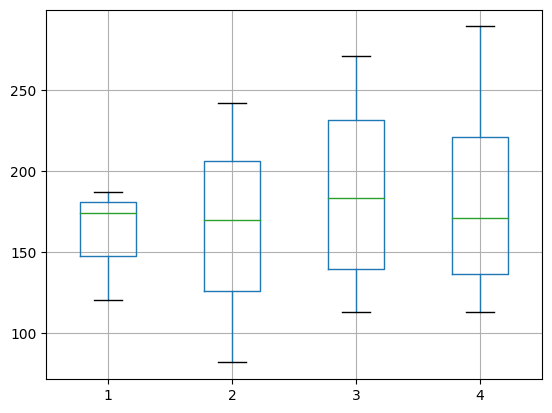

In [ ]:
Quarterly_mean.boxplot()

In [ ]:
Monthly = pd.pivot_table(data=df1,index= df1.index.year, columns = df1.index.month,values = "price", aggfunc = {"price" : "mean"})
Monthly = Monthly.rename_axis(["Year"])
Monthly = Monthly.rename_axis(["Months"],axis = 1)
Monthly

Months,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2018,NaN,NaN,NaN,NaN,NaN,NaN,215.582679,218.345443,220.844276,202.028694,197.631128,193.899183
2019,190.867898,156.578001,172.495279,180.509131,160.492079,168.653731,166.830083,134.464638,144.144427,144.446798,144.818282,143.689843
2020,150.732817,134.670903,79.511711,69.713928,79.255677,95.619822,101.423768,115.583767,122.651425,102.091340,99.505874,135.768366
2021,163.743959,179.785520,212.523399,215.839192,259.943762,250.700643,249.293320,281.161545,281.282905,291.263195,283.213346,NaN


<Axes: title={'center': 'Vedanta Monthly average opening price'}, xlabel='Years', ylabel='opening price'>

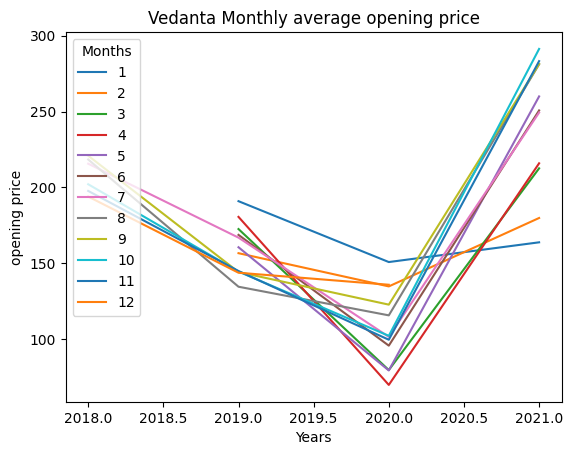

In [ ]:
Monthly.plot(xlabel = "Years",ylabel = "opening price",title = "Vedanta Monthly average opening price")

<Axes: >

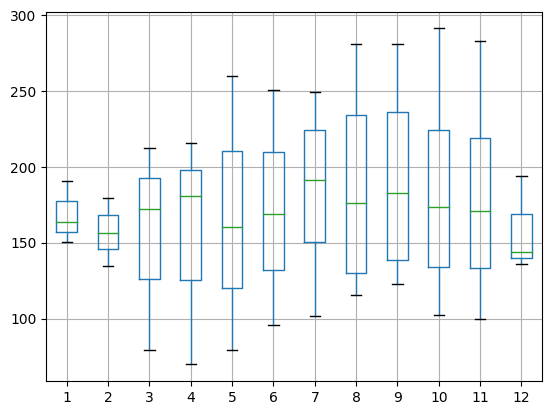

In [ ]:
Monthly.boxplot()

Observations:  

1.   There is no clear Quarter or month in which Vedanta consistently acheives its best stock price but Jan, Feb and Dec seems to not fluctuate as heavily as other months.
2.   It can be observed that 2020 was the worst year. After Covid, stock price seems to be strongly rallying up.

3.   From boxplots we do not observe any outliers which need to be treated.





In [ ]:
#SPLITTING INTO TRAIN AND TEST SET

train = df1[:int(len(df1)*0.8)]
test = df1[int(len(df)*0.8):]
print(len(train))
print(len(test))

675
169


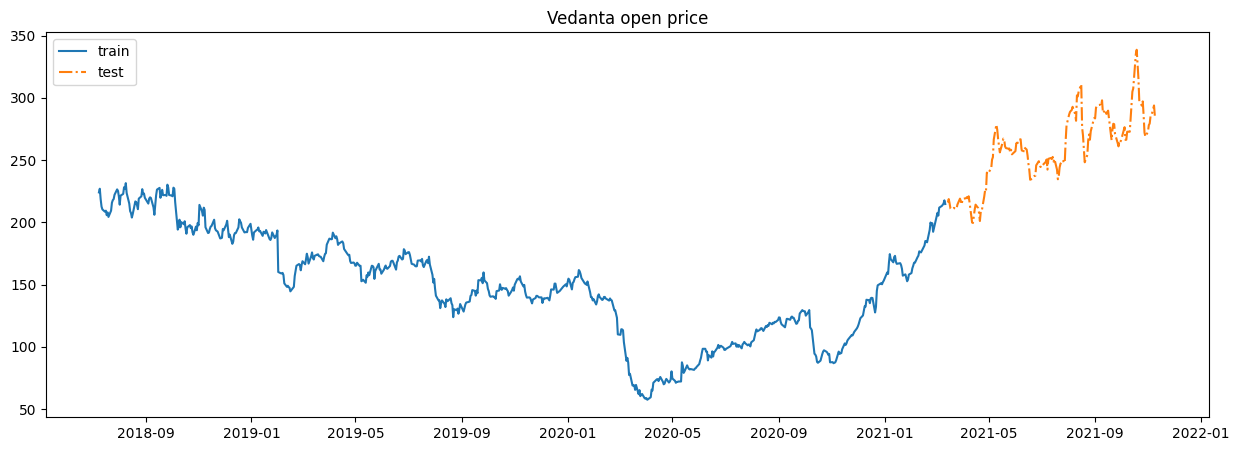

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(train, label = "train")
plt.plot(test,label = "test",linestyle = "-.")
plt.legend()
plt.title("Vedanta open price")
plt.show()

1) Moving Average method (MA)

Moving average is useful for identifying trends and potential support/resistance. They cannot be used to predict future values.

In [ ]:
def MAPE(y,yhat):
  y,yhat = np.array(y),np.array(yhat)
  try:
    mape = np.round(np.sum(np.abs(yhat-y))/np.sum(y)*100,2)
  except:
    print("values are empty")
    mape = np.nan
  return mape


In [ ]:
def RMSE(y,yhat):
  y,yhat = np.array(y),np.array(yhat)
  rmse = sqrt(mean_squared_error(y,yhat))
  return np.round(rmse,3)

In [ ]:
madf = df1.copy()

madf["moving_average_forecast_4"] = df1["price"].rolling(4).mean()
madf["moving_average_forecast_6"] = df1["price"].rolling(6).mean()
madf["moving_average_forecast_8"] = df1["price"].rolling(8).mean()
madf["moving_average_forecast_12"] = df1["price"].rolling(12).mean()

In [ ]:
results_df = pd.DataFrame()

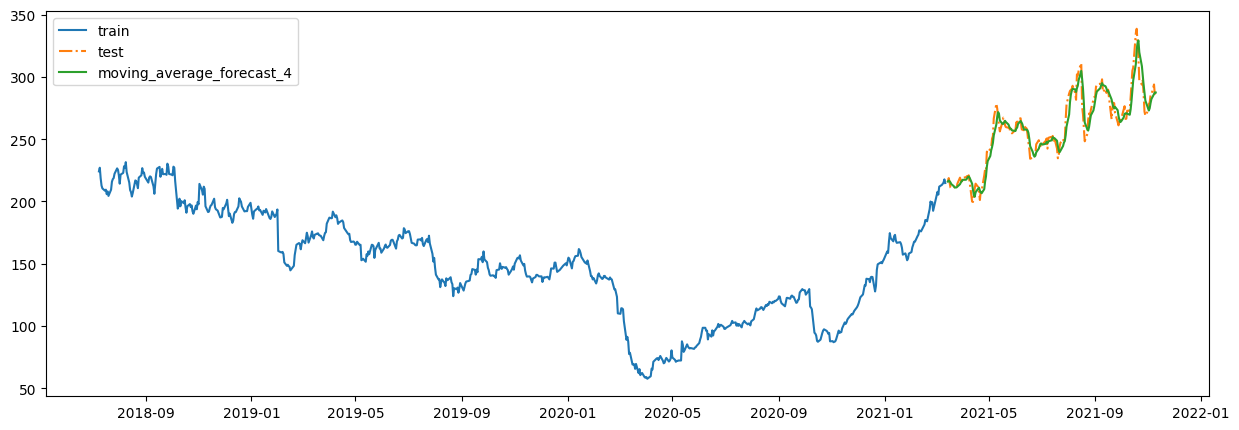

The RMSE of the moving_average_forecast_4 is 7.54 and MAPE is 2.16


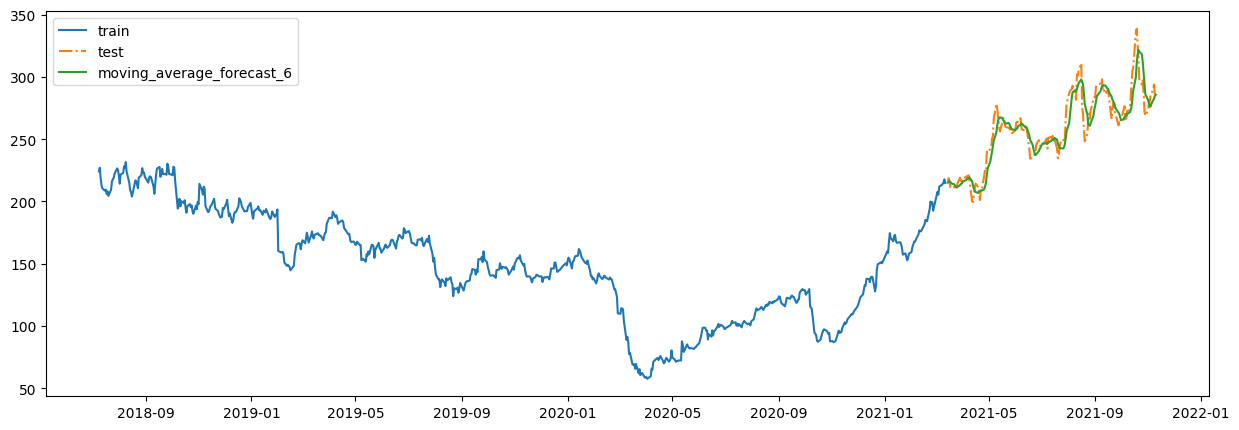

The RMSE of the moving_average_forecast_6 is 10.258 and MAPE is 2.91


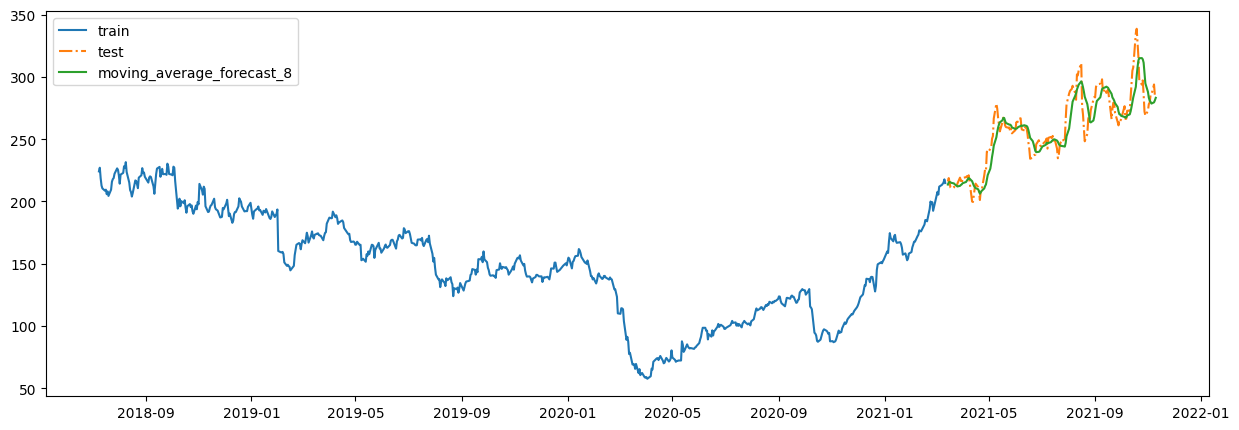

The RMSE of the moving_average_forecast_8 is 12.272 and MAPE is 3.47


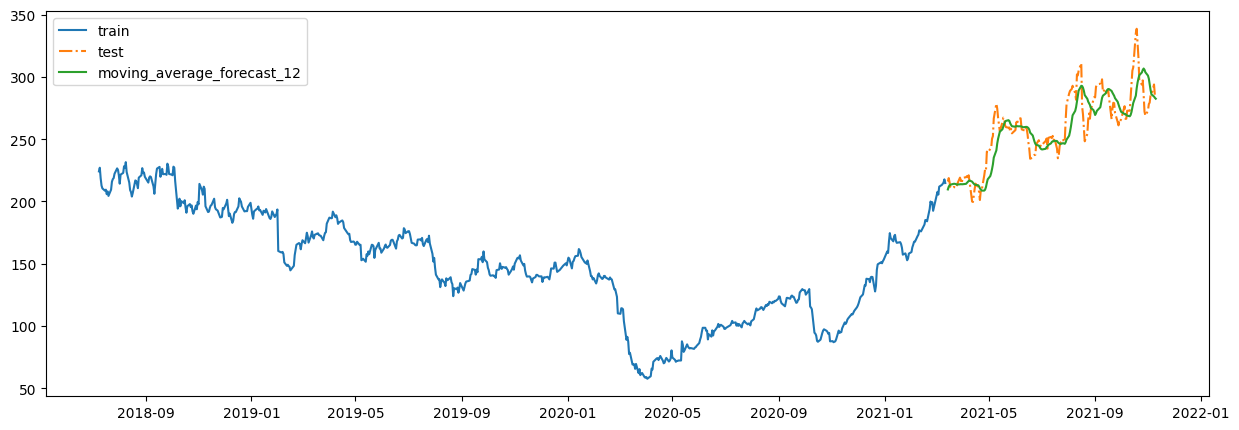

The RMSE of the moving_average_forecast_12 is 15.166 and MAPE is 4.34


In [ ]:
cols = ["moving_average_forecast_4","moving_average_forecast_6","moving_average_forecast_8","moving_average_forecast_12"]

train = madf[:int(len(df1)*0.8)]
test = madf[int(len(df1)*0.8):]

y_hat_avg = test.copy()

for forecast in cols:
  plt.figure(figsize=(15,5))
  plt.plot(train["price"],label="train")
  plt.plot(test["price"],label= "test", linestyle ="-.")
  plt.plot(y_hat_avg[forecast],label = forecast)
  plt.legend()
  plt.show()

  mape = MAPE(y_hat_avg[forecast],test["price"])
  rmse = RMSE(y_hat_avg[forecast],test["price"])

  print("The RMSE of the {} is {} and MAPE is {}".format(forecast,rmse,mape))

  temp_df = pd.DataFrame({"model":[forecast],"rmse":[rmse],"mape":[mape]})
  results_df = pd.concat([results_df,temp_df])


In [ ]:
results_df

,model,rmse,mape
0,moving_average_forecast_4,7.540,2.16
0,moving_average_forecast_6,10.258,2.91
0,moving_average_forecast_8,12.272,3.47
0,moving_average_forecast_12,15.166,4.34


2) Holt Winters Method (Triple Exponential Smoothening)

In [ ]:
winters = ExponentialSmoothing(np.asarray(train["price"]),trend = "additive",damped= False,seasonal = "additive",seasonal_periods=12).fit(optimized=True, use_brute=True)
print(winters.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  675
Model:             ExponentialSmoothing   SSE                          11842.784
Optimized:                         True   AIC                           1965.714
Trend:                         Additive   BIC                           2037.949
Seasonal:                      Additive   AICC                          1966.757
Seasonal Periods:                    12   Date:                 Sat, 08 Jul 2023
Box-Cox:                          False   Time:                         15:48:45
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

<ipython-input-361-1b049d69443f>:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  winters = ExponentialSmoothing(np.asarray(train["price"]),trend = "additive",damped= False,seasonal = "additive",seasonal_periods=12).fit(optimized=True, use_brute=True)


The triple exponential smoothing(additive) has the following performance metrics:
 rmse=>17.514
 mape=>5.69


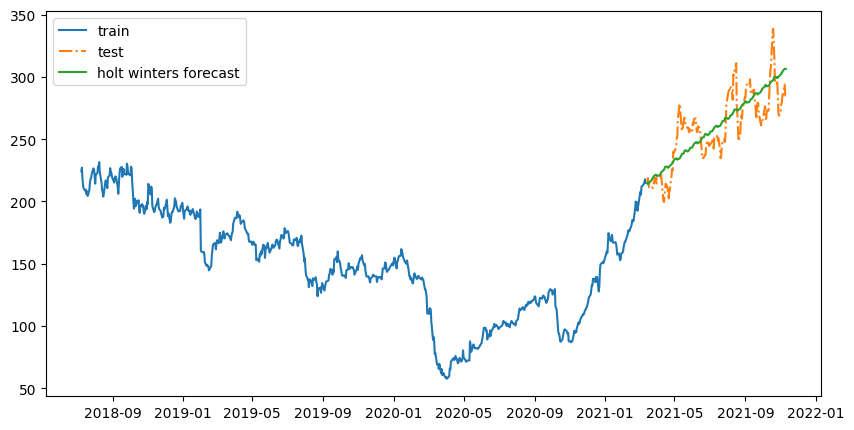

In [ ]:
y_hat = winters.forecast(steps = 169)

plt.figure(figsize=(10,5))
plt.plot(train["price"],label = "train")
plt.plot(test["price"],label = "test", linestyle = "-.")
plt.plot(test.index,y_hat,label = "holt winters forecast")
plt.legend()
plt.plot()

rmse = RMSE(np.asarray(y_hat),test["price"])
mape = MAPE(np.asarray(y_hat),test["price"])

print("The triple exponential smoothing(additive) has the following performance metrics:\n rmse=>{}\n mape=>{}".format(rmse,mape))

winter_result = pd.DataFrame({"model":"Triple Exponential(additive)","rmse":[rmse],"mape":[mape]})
results_df = pd.concat([results_df,winter_result])

In [ ]:
winters_mul = ExponentialSmoothing(np.asarray(train["price"]),trend = "additive",damped= False,seasonal = "multiplicative",seasonal_periods=12).fit(optimized=True, use_brute=True)
print(winters_mul.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  675
Model:             ExponentialSmoothing   SSE                          11823.404
Optimized:                         True   AIC                           1964.608
Trend:                         Additive   BIC                           2036.844
Seasonal:                Multiplicative   AICC                          1965.651
Seasonal Periods:                    12   Date:                 Sat, 08 Jul 2023
Box-Cox:                          False   Time:                         15:48:57
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

<ipython-input-363-576a035de151>:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  winters_mul = ExponentialSmoothing(np.asarray(train["price"]),trend = "additive",damped= False,seasonal = "multiplicative",seasonal_periods=12).fit(optimized=True, use_brute=True)


The triple exponential smoothing(multiplicative) has the following performance metrics:
 rmse=>17.402
 mape=>5.62


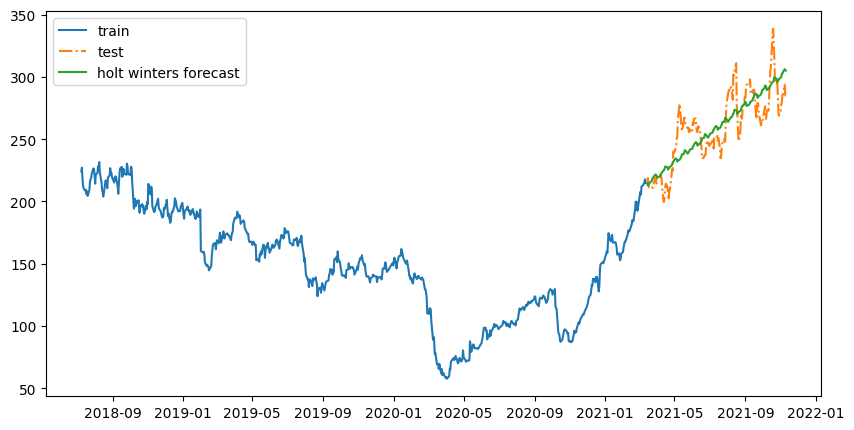

In [ ]:
y_hat = winters_mul.forecast(steps = 169)

plt.figure(figsize=(10,5))
plt.plot(train["price"],label = "train")
plt.plot(test["price"],label = "test", linestyle = "-.")
plt.plot(test.index,y_hat,label = "holt winters forecast")
plt.legend()
plt.plot()

rmse = RMSE(np.asarray(y_hat),test["price"])
mape = MAPE(np.asarray(y_hat),test["price"])

print("The triple exponential smoothing(multiplicative) has the following performance metrics:\n rmse=>{}\n mape=>{}".format(rmse,mape))

winter_mul_result = pd.DataFrame({"model":"Triple Exponential(multiplicative)","rmse":[rmse],"mape":[mape]})
results_df = pd.concat([results_df,winter_mul_result])

In [ ]:
results_df

,model,rmse,mape
0,moving_average_forecast_4,7.540,2.16
0,moving_average_forecast_6,10.258,2.91
0,moving_average_forecast_8,12.272,3.47
0,moving_average_forecast_12,15.166,4.34
0,Triple Exponential(additive),17.514,5.69
0,Triple Exponential(multiplicative),17.402,5.62


3) AR model : ARIMA

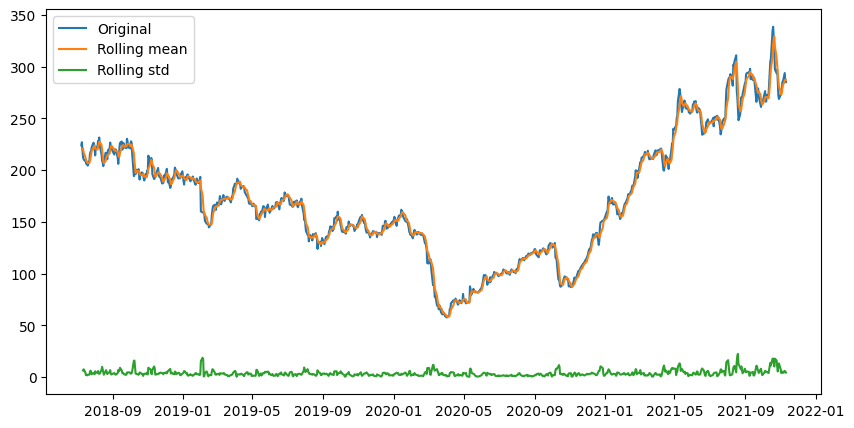

In [ ]:
#Determining Rolling statistics

rollmean = df1["price"].rolling(4).mean()
rollstd = df1["price"].rolling(4).std()


plt.figure(figsize =(10,5))
plt.plot(df1["price"], label = "Original")
plt.plot(rollmean, label = "Rolling mean")
plt.plot(rollstd,label = "Rolling std")
plt.legend()
plt.show()

Statistical Tests to confirm stationarity or type non stationarity

In [ ]:
#Augmented Dickey Fuller Test

dftest = adfuller(df1["price"])
print("The ADF test statistic is {}".format(np.round(dftest[0],3)))
print("the ADF p value is {}".format(np.round(dftest[1],3)))

The ADF test statistic is -0.831
the ADF p value is 0.81


In [ ]:

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df1["price"], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.831212
p-value                          0.809781
#Lags Used                       1.000000
Number of Observations Used    842.000000
Critical Value (1%)             -3.438140
Critical Value (5%)             -2.864979
Critical Value (10%)            -2.568601
dtype: float64


Since p value is 0.81(pretty high) our test result is reliable and since p-value is less negative than all critical values,we fail to reject the null hypothesis. Therefore our time series is non stationary.

In [ ]:
#KPSS Test
print ('Results of KPSS Test:')
kpsstest = kpss(df1["price"], regression='c', nlags="auto")
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

Results of KPSS Test:
Test Statistic            1.115765
p-value                   0.010000
#Lags Used               18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test statistic is higher than all critical values and p values is smaller than 0.05. We can reject null hypothesis and confirm that the Time Series is not stationary according to KPSS test as well.

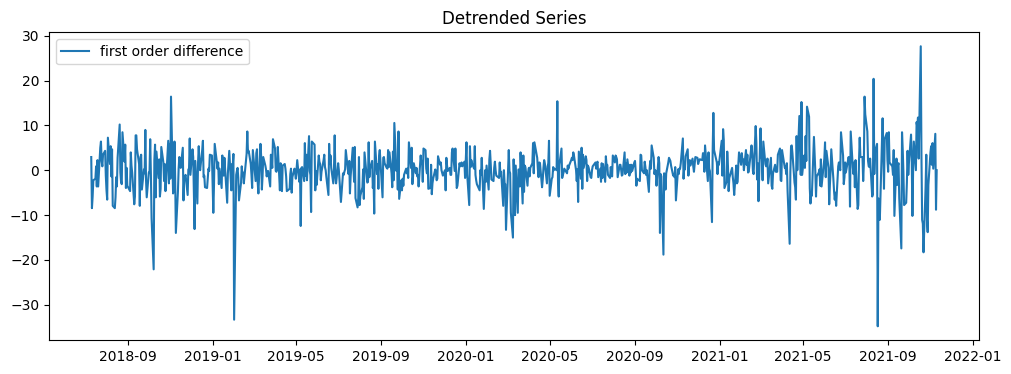

In [ ]:
#Detrending

plt.figure(figsize=(12, 4))
plt.plot(df1["price"].diff(periods=1),label = "first order difference")
plt.title("Detrended Series")
plt.legend()

In [ ]:
ts_diff = df1["price"].diff(periods=1)
ts_diff.dropna(inplace = True)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 200x200 with 0 Axes>

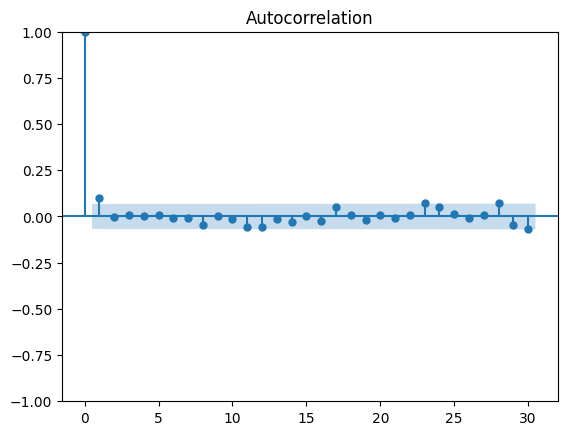

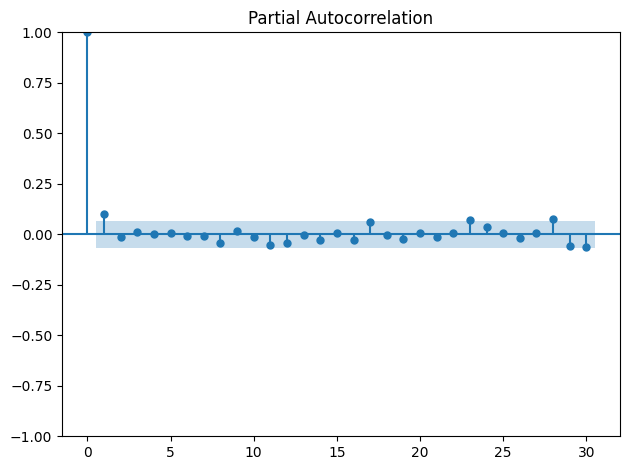

In [ ]:
#Checking AutoCorrelation

plt.figure(figsize=(2,2))
smt.graphics.plot_acf(ts_diff, lags=30)
smt.graphics.plot_pacf(ts_diff, lags=30)
plt.tight_layout()
plt.show()

The time series has decayed and remains within the significance range. This is indicative of stationary series.

In [ ]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -26.174596
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    842.000000
Critical Value (1%)             -3.438140
Critical Value (5%)             -2.864979
Critical Value (10%)            -2.568601
dtype: float64


ADF Test Statistic is way more negative than all critical values and p-value is less than 0.05. Therefore we reject the null hypothesis. This strongly suggests than we have succeeded in converting our time series to a stationary time series.

In [ ]:
print ('Results of KPSS Test:')
kpsstest = kpss(ts_diff, regression='c', nlags="auto")
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

Results of KPSS Test:
Test Statistic           0.421178
p-value                  0.068027
#Lags Used               4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


KPSS statistic is not large enough to reject the null hypothesis. p-value is also above 0.05. Therefore we fail to reject null hypothesis. Both the test statistics as well as ACF and PACF charts have helped us to confirm that our time series is stationary.

This allows us to use ARIMA models on our time series data.

In [ ]:
model=ARIMA(df1["price"],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                  844
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2543.162
Date:                Sat, 08 Jul 2023   AIC                           5092.325
Time:                        15:49:54   BIC                           5106.536
Sample:                             0   HQIC                          5097.770
                                - 844                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0317      0.266     -0.119      0.905      -0.553       0.490
ma.L1          0.1348      0.268      0.503      0.615      -0.390       0.660
sigma2        24.4275      0.541     45.146      0.000      23.367      25.488
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2206.93
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


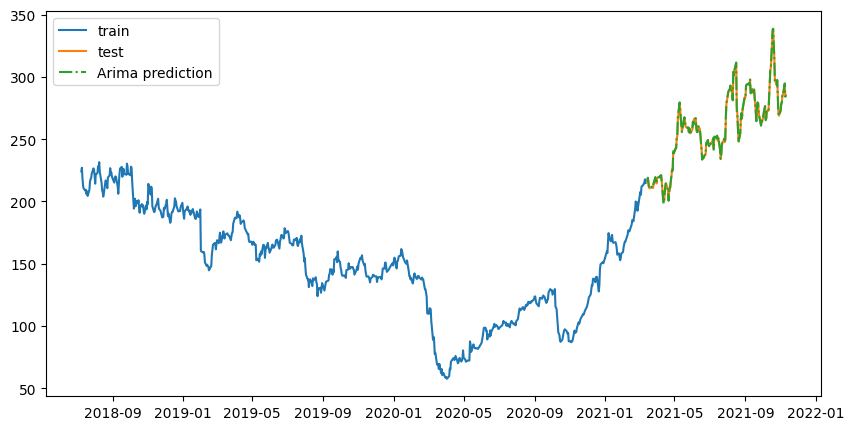

The performance metrics of ARIMA model is as follows:
 rmse=> 0.724
 mape=> 0.2


In [ ]:
y_hat = model_fit.predict(start=676,end=844,dynamic=False)

plt.figure(figsize=(10,5))
plt.plot(train["price"],label ="train")
plt.plot(test["price"],label= "test")
plt.plot(test.index,y_hat,label = "Arima prediction", linestyle = "-.")
plt.legend()
plt.show()

mape = MAPE(np.asarray(y_hat),test["price"])
rmse = RMSE(np.asarray(y_hat),test["price"])

print("The performance metrics of ARIMA model is as follows:\n rmse=> {}\n mape=> {}".format(rmse,mape))

arima_result = pd.DataFrame({"model": "Arima","mape":[mape],"rmse":[rmse]})
results_df = pd.concat([results_df,arima_result])

In [ ]:
sarima=SARIMAX(df1["price"],order=(1,1,1),seasonal_order=(1,1,1,12))
sarimax_fit=sarima.fit()
sarimax_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                  844
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2529.228
Date:                            Sat, 08 Jul 2023   AIC                           5068.455
Time:                                    15:50:07   BIC                           5092.068
Sample:                                         0   HQIC                          5077.510
                                            - 844                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1580      0.275     -0.574      0.566      -0.698       0.382
ma.L1          0.2495      0.273      0.915      0.360      -0.285       0.784
ar.S.L12      -0.0685      0.033     -2.072      0.038      -0.133      -0.004
ma.S.L12      -0.9613      0.018    -52.947      0.000      -0.997      -0.926
sigma2        24.7859      0.668     37.114      0.000      23.477      26.095
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2073.03
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


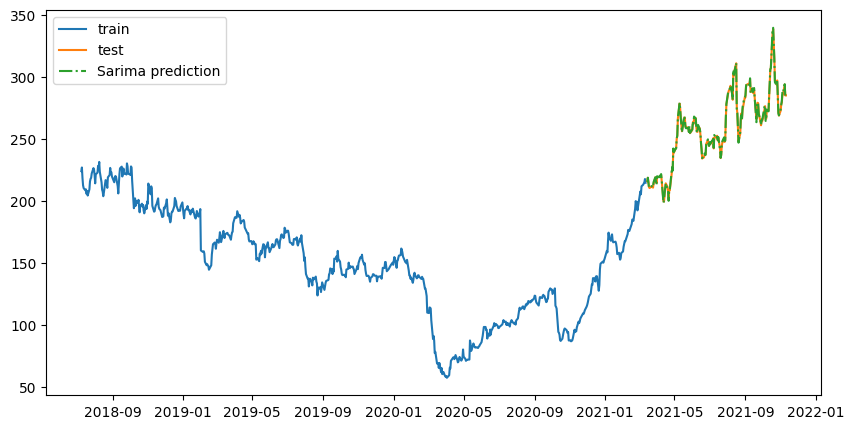

The performance metrics of SARIMAX model is as follows:
 rmse=> 1.123
 mape=> 0.33


In [ ]:
y_hat = sarimax_fit.predict(start=676,end=844,dynamic=False)

plt.figure(figsize=(10,5))
plt.plot(train["price"],label ="train")
plt.plot(test["price"],label= "test")
plt.plot(test.index,y_hat,label = "Sarima prediction", linestyle = "-.")
plt.legend()
plt.show()

mape = MAPE(np.asarray(y_hat),test["price"])
rmse = RMSE(np.asarray(y_hat),test["price"])

print("The performance metrics of SARIMAX model is as follows:\n rmse=> {}\n mape=> {}".format(rmse,mape))

sarima_result = pd.DataFrame({"model": "Sarimax","mape":[mape],"rmse":[rmse]})
results_df = pd.concat([results_df,sarima_result])

In [ ]:
results_df

,model,rmse,mape
0,moving_average_forecast_4,7.540,2.16
0,moving_average_forecast_6,10.258,2.91
0,moving_average_forecast_8,12.272,3.47
0,moving_average_forecast_12,15.166,4.34
0,Triple Exponential(additive),17.514,5.69
0,Triple Exponential(multiplicative),17.402,5.62
0,Arima,0.724,0.20
0,Sarimax,1.123,0.33


From all these models Sarimax model performs best based our performance metrics. However this would not be the case in the real world as we have trained ARIMA and SARIMA models on our test dataset as well.

In [ ]:
truemodel=ARIMA(train["price"],order=(1,1,1))
true_arima_model_fit=truemodel.fit()
true_arima_model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                  675
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1930.304
Date:                Sat, 08 Jul 2023   AIC                           3866.608
Time:                        15:52:05   BIC                           3880.148
Sample:                             0   HQIC                          3871.851
                                - 675                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2663      1.552     -0.172      0.864      -3.308       2.776
ma.L1          0.2873      1.541      0.186      0.852      -2.734       3.308
sigma2        17.9919      0.447     40.269      0.000      17.116      18.868
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1797.86
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


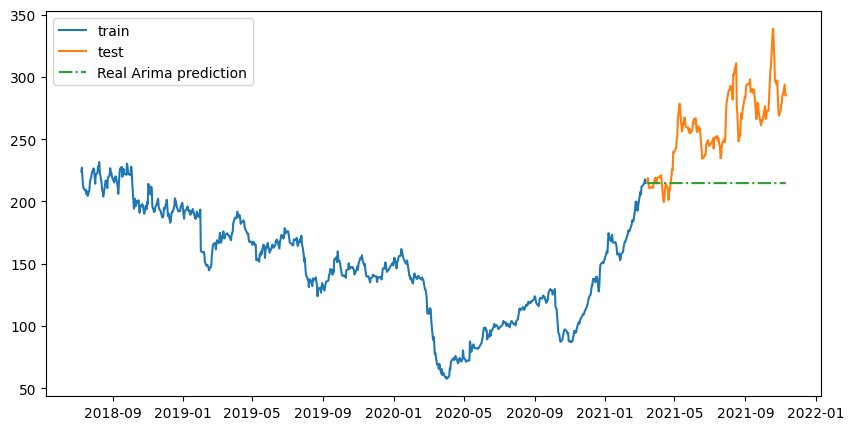

The real performance metrics of ARIMA model is as follows:
 rmse=> 52.91
 mape=> 21.1


In [ ]:
y_hat = true_arima_model_fit.predict(start=676,end=844,dynamic=False)

plt.figure(figsize=(10,5))
plt.plot(train["price"],label ="train")
plt.plot(test["price"],label= "test")
plt.plot(test.index,y_hat,label = "Real Arima prediction", linestyle = "-.")
plt.legend()
plt.show()

mape = MAPE(np.asarray(y_hat),test["price"])
rmse = RMSE(np.asarray(y_hat),test["price"])

print("The real performance metrics of ARIMA model is as follows:\n rmse=> {}\n mape=> {}".format(rmse,mape))

true_arima_result = pd.DataFrame({"model": "Real Arima","mape":[mape],"rmse":[rmse]})
results_df = pd.concat([results_df,true_arima_result])

In [ ]:
real_sarima=SARIMAX(train["price"],order=(1,1,1),seasonal_order=(1,1,1,12))
real_sarimax_fit=real_sarima.fit()
real_sarimax_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                  675
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1915.966
Date:                            Sat, 08 Jul 2023   AIC                           3841.932
Time:                                    15:52:16   BIC                           3864.408
Sample:                                         0   HQIC                          3850.643
                                            - 675                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9487      0.087     10.853      0.000       0.777       1.120
ma.L1         -0.9258      0.102     -9.119      0.000      -1.125      -0.727
ar.S.L12      -0.0644      0.037     -1.749      0.080      -0.137       0.008
ma.S.L12      -0.9957      0.189     -5.275      0.000      -1.366      -0.626
sigma2        17.8144      3.143      5.667      0.000      11.654      23.975
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1677.34
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


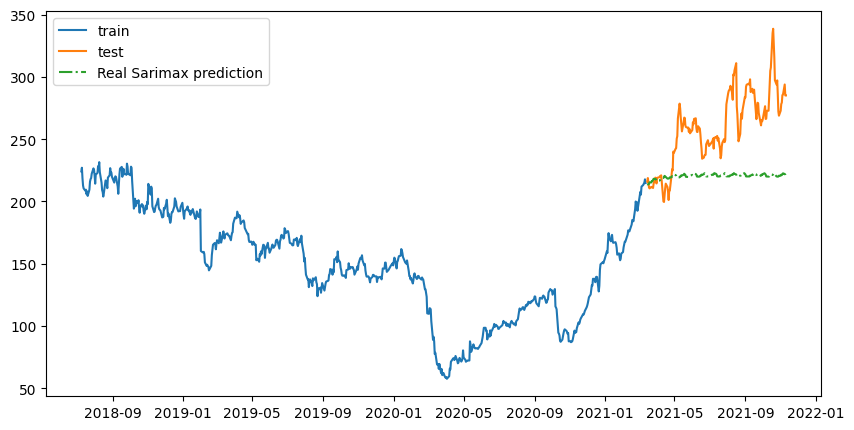

The Real performance metrics of SARIMAX model is as follows:
 rmse=> 47.728
 mape=> 18.34


In [ ]:
y_hat = real_sarimax_fit.predict(start=676,end=844,dynamic=False)

plt.figure(figsize=(10,5))
plt.plot(train["price"],label ="train")
plt.plot(test["price"],label= "test")
plt.plot(test.index,y_hat,label = "Real Sarimax prediction", linestyle = "-.")
plt.legend()
plt.show()

mape = MAPE(np.asarray(y_hat),test["price"])
rmse = RMSE(np.asarray(y_hat),test["price"])

print("The Real performance metrics of SARIMAX model is as follows:\n rmse=> {}\n mape=> {}".format(rmse,mape))

real_sarima_result = pd.DataFrame({"model": "Real Sarimax","mape":[mape],"rmse":[rmse]})
results_df = pd.concat([results_df,real_sarima_result])

In [ ]:
results_df

,model,rmse,mape
0,moving_average_forecast_4,7.540,2.16
0,moving_average_forecast_6,10.258,2.91
0,moving_average_forecast_8,12.272,3.47
0,moving_average_forecast_12,15.166,4.34
0,Triple Exponential(additive),17.514,5.69
0,Triple Exponential(multiplicative),17.402,5.62
0,Arima,0.724,0.20
0,Sarimax,1.123,0.33
0,Real Arima,52.910,21.10
0,Real Sarimax,47.728,18.34


As we cannot use moving average to predict future values, Triple Exponential smoothing or Holt Winters model has the ability to make best predictions on this dataset. Triple exponential smoothing is the winner here.